![example](images/director_shot.jpeg)

# Project Title

## **Author:** Madeleine Reiser
***

## Overview

This project used exploratory data analysis to help the business stake owners of a potential new movie streaming service figure out the best ways to make box office revenue. Datasets from IMDB and Box Office Mojo were analyzed to show what movies have made the most money, which are the highest rated, and which are the most popular, from the years 2010-2018. 

## Business Problem

Microsoft Stake Owners are interested in developing their own streaming service but aren’t sure what kinds of movies do the best in the box office. 


## Data Understanding

Using datasets from IMDB and Box Office Mojo, this project explores how box office revenue is correlated with variables such as ratings, popularity (which is measured by number of reviews left by viewers), specific studios and genres.  


## Import necessary packages and load Datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import requests
import re
from bs4 import BeautifulSoup
%matplotlib inline

In [3]:
#load data 
imdb_title_ratings = pd.read_csv('imdb.title.ratings.csv.gz')
imdb_title_basics = pd.read_csv('imdb.title.basics.csv.gz')
bom_movie_gross = pd.read_csv('bom.movie_gross.csv.gz')

## IMDB Ratings Dataset

Contains "tconst", which appears to be the code for each movie, the film's average rating, and the number of votes on IMDB

In [4]:
imdb_title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [5]:
imdb_title_ratings.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## IMDB Basic Dataset

Contains more information for each film on IMDB including "tconst" again, Primary and Original titles, start year, runtime in minutes, and the genre. 

In [6]:
imdb_title_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


## Box Office Mojo dataset

Contains the title, studio, domestic gross, foreign gross and year released according to data from Box Office Mojo 

In [7]:
bom_movie_gross.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [8]:
bom_movie_gross.describe()


,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

## Box Office Mojo dataset

In [9]:
bom_movie_gross = pd.read_csv('bom.movie_gross.csv.gz')
bom_movie_gross.sort_values(by='year', ascending=False)
bom_movie_gross.sort_values(by='domestic_gross', ascending=False).head(30)
bom_movie_gross.info()
#last year is 2018
#includes studio
#foreign_gross is an object
bom_movie_gross.columns = ['Title', 'Studio', 'Domestic Gross', 
                        'Foreign Gross', 'BOM Year']
bom_movie_gross

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,Title,Studio,Domestic Gross,Foreign Gross,BOM Year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


## Merging the two IMDB Sets

I merged both IMDB Datasets to keep all IMDB data together. 

In [10]:
#Join imdb_title_basics and imdb_title_ratings 
imdb_ratings_joined = imdb_title_basics.merge(imdb_title_ratings, on = 'tconst',  how = 'outer')
imdb_ratings_joined.sort_values(by = 'start_year', ascending = False)
#data begins at 2010 and goes up to 2115, limit year to 2010-2018


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
89506,tt5174640,100 Years,100 Years,2115,NaN,Drama,NaN,NaN
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy",NaN,NaN
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy,NaN,NaN
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy",NaN,NaN
105187,tt6149054,Fantastic Beasts and Where to Find Them 5,Fantastic Beasts and Where to Find Them 5,2024,NaN,"Adventure,Family,Fantasy",NaN,NaN
...,...,...,...,...,...,...,...,...
74712,tt4264626,Civil War Life: Shot to Pieces,Civil War Life: Shot to Pieces,2010,79.0,Documentary,5.7,6.0
14471,tt1716746,Heinrich Kieber - Datendieb,Heinrich Kieber - Datendieb,2010,52.0,Documentary,7.7,6.0
74692,tt4263706,Mushrooms of America,Mushrooms of America,2010,46.0,"Adventure,Comedy,Documentary",NaN,NaN
118065,tt7059624,Zamana,Zamana,2010,140.0,Drama,NaN,NaN


I renamed the columns to make them more readable. 

In [11]:
imdb_ratings_joined.columns = ['tconst', 'Title', 'Original Title', 
                               'IMDB Year', 'Runtime (in minutes)', 
                              'Genres', 'Average Rating', 'Number of Votes']
imdb_ratings_joined.sort_values(by = 'IMDB Year')

,tconst,Title,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
9599,tt1566491,Brainiacs in La La Land,Brainiacs in La La Land,2010,NaN,Comedy,NaN,NaN
43264,tt2578092,Fireplace for your Home: Crackling Fireplace w...,Fireplace for your Home: Crackling Fireplace w...,2010,61.0,Music,6.9,17.0
11550,tt1634300,Role/Play,Role/Play,2010,85.0,"Drama,Romance",5.0,894.0
11551,tt1634332,Johan1,Johan Primero,2010,78.0,"Comedy,Drama,Romance",7.1,124.0
11552,tt1634334,Hands Up,Les mains en l'air,2010,90.0,Drama,6.2,271.0
...,...,...,...,...,...,...,...,...
2948,tt10300396,Untitled Star Wars Film,Untitled Star Wars Film,2024,NaN,NaN,NaN,NaN
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy",NaN,NaN
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy,NaN,NaN
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy",NaN,NaN


I limited the data from the joined IMDB datasets to 2018, which is the last year this set was updated. 

In [12]:
#get relevant years (2010-2018) 
imdb_ratings_joined2010_2018 = imdb_ratings_joined.loc[imdb_ratings_joined['IMDB Year'] <= 2018]
imdb_ratings_joined2010_2018.sort_values(by = 'IMDB Year', ascending = False)
imdb_ratings_joined2010_2018.sort_values(by = 'Average Rating', ascending = False)



,tconst,Title,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
85712,tt4960818,Revolution Food,Revolution Food,2015,70.0,Documentary,10.0,8.0
117359,tt6991826,A Dedicated Life: Phoebe Brand Beyond the Group,A Dedicated Life: Phoebe Brand Beyond the Group,2015,93.0,Documentary,10.0,5.0
44279,tt2632430,Hercule contre Hermès,Hercule contre Hermès,2012,72.0,Documentary,10.0,5.0
4016,tt10378660,The Dark Knight: The Ballad of the N Word,The Dark Knight: The Ballad of the N Word,2018,129.0,"Comedy,Drama",10.0,5.0
1857,tt10176328,Exteriores: Mulheres Brasileiras na Diplomacia,Exteriores: Mulheres Brasileiras na Diplomacia,2018,52.0,Documentary,10.0,5.0
...,...,...,...,...,...,...,...,...
146136,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,Documentary,NaN,NaN
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary,NaN,NaN
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy,NaN,NaN
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN,NaN,NaN


I dropped rows where average rating is NaN


In [13]:
rating_na_dropped = imdb_ratings_joined2010_2018[imdb_ratings_joined2010_2018['Average Rating'].notna()]


I limited the average rating to 8 or better, and show the value counts per genre. This merged dataset doesn't include data from BOM, only IMDB.

In [14]:
#limit average rating to 8 or better
rating_na_dropped.loc[rating_na_dropped['Average Rating'] >= 8]
imdb_8_or_better = rating_na_dropped.loc[rating_na_dropped['Average Rating'] >= 8]
#genres where rating was better than an 8
imdb_8_or_better['Genres'].value_counts().head(10)


Documentary                      2715
Drama                            1234
Comedy                            402
Comedy,Drama                      220
Documentary,Music                 204
Documentary,Drama                 158
Biography,Documentary             155
Biography,Documentary,History     142
Documentary,History               131
Biography,Documentary,Drama       117
Name: Genres, dtype: int64

## Merge the BOM dataset with the IMDB dataset

Joined the tables by 'Title', and dropped the year given by BOM since we already have the year from IMDB, which provides most of the data. 

In [15]:
alljoined = bom_movie_gross.merge(rating_na_dropped, on = 'Title',  how = 'inner')
alljoined
#sort by # votes, gives best idea of rating
alljoined.sort_values(by = 'Domestic Gross', ascending = False)


#dropping BOM year because it has the least entries and most of 
#the data is from IMDB 
alljoined.drop_duplicates()
alljoined.drop(['BOM Year'], axis='columns', inplace=True)
alljoined.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3015 non-null   object 
 1   Studio                3012 non-null   object 
 2   Domestic Gross        2993 non-null   float64
 3   Foreign Gross         1821 non-null   object 
 4   tconst                3015 non-null   object 
 5   Original Title        3015 non-null   object 
 6   IMDB Year             3015 non-null   int64  
 7   Runtime (in minutes)  2970 non-null   float64
 8   Genres                3008 non-null   object 
 9   Average Rating        3015 non-null   float64
 10  Number of Votes       3015 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 282.7+ KB


I further sliced the dataset to limit results to any films with an average rating of 8 or better to explore which films are highest rated

In [16]:
alljoined_8_or_better = alljoined.loc[alljoined['Average Rating'] >= 8]
#limit alljoined table to ratings 8 or better
alljoined_8_or_better.sort_values(by = 'Average Rating')
alljoined_8_or_better['Genres'].value_counts()

Drama                         18
Documentary                   10
Action,Adventure,Sci-Fi        4
Adventure,Animation,Comedy     4
Drama,Thriller                 3
                              ..
Drama,Sport                    1
Biography,Comedy,Drama         1
Crime                          1
Action                         1
Comedy,Documentary,Drama       1
Name: Genres, Length: 69, dtype: int64

In [17]:
alljoined.sort_values(by = 'Domestic Gross', ascending = False)

,Title,Studio,Domestic Gross,Foreign Gross,tconst,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
2740,Black Panther,BV,700100000.0,646900000,tt1825683,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0
2739,Avengers: Infinity War,BV,678800000.0,"1,369.5",tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
1608,Jurassic World,Uni.,652300000.0,"1,019.4",tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0
2424,Star Wars: The Last Jedi,BV,620200000.0,712400000,tt2527336,Star Wars: Episode VIII - The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",7.1,462903.0
2742,Incredibles 2,BV,608600000.0,634200000,tt3606756,Incredibles 2,2018,118.0,"Action,Adventure,Animation",7.7,203510.0
...,...,...,...,...,...,...,...,...,...,...,...
2162,Solace,LGP,NaN,22400000,tt2140411,Solace,2013,76.0,Thriller,7.2,59.0
2163,Solace,LGP,NaN,22400000,tt3240102,Solace,2018,81.0,Drama,4.9,28.0
2281,Viral,W/Dim.,NaN,552000,tt2594078,Viral,2013,95.0,"Comedy,Horror,Thriller",4.4,227.0
2282,Viral,W/Dim.,NaN,552000,tt2597892,Viral,2016,85.0,"Drama,Horror,Sci-Fi",5.5,7150.0


Created a master dataframe by merging the BOM dataset with the merged IMDB datasets

In [18]:
alljoined = bom_movie_gross.merge(rating_na_dropped, on = 'Title',  how = 'inner')
alljoined['Foreign Gross'] = pd.to_numeric(alljoined['Foreign Gross'], errors = 'coerce')
alljoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 3015 non-null   object 
 1   Studio                3012 non-null   object 
 2   Domestic Gross        2993 non-null   float64
 3   Foreign Gross         1817 non-null   float64
 4   BOM Year              3015 non-null   int64  
 5   tconst                3015 non-null   object 
 6   Original Title        3015 non-null   object 
 7   IMDB Year             3015 non-null   int64  
 8   Runtime (in minutes)  2970 non-null   float64
 9   Genres                3008 non-null   object 
 10  Average Rating        3015 non-null   float64
 11  Number of Votes       3015 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 306.2+ KB


## Data Modeling

I first created a correlation matrix to see which variables have a relationship with "Domestic Gross" or "Foreign Gross" 

[Text(0, 0.5, 'Domestic Gross'),
 Text(0, 1.5, 'Foreign Gross'),
 Text(0, 2.5, 'BOM Year'),
 Text(0, 3.5, 'IMDB Year'),
 Text(0, 4.5, 'Runtime (in minutes)'),
 Text(0, 5.5, 'Average Rating'),
 Text(0, 6.5, 'Number of Votes')]

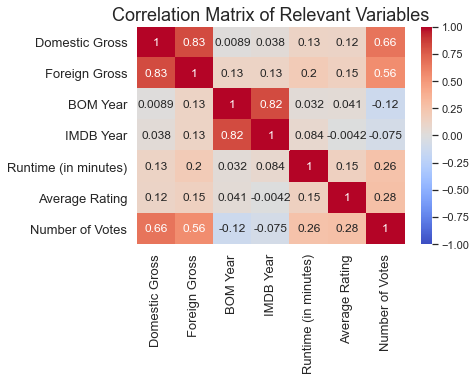

In [430]:
ax = plt.axes()
sns.set(font_scale = 1)
sns.heatmap(alljoined.corr(), ax = ax, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

ax.set_title('Correlation Matrix of Relevant Variables', fontsize = 18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 13)
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 13)

#Notable correlations: 
#Domestic & Foreign Gross = .83 
#Num Votes & FG = .56
#Num Votes & DG = .66
#Average Rating & Num Votes = .28

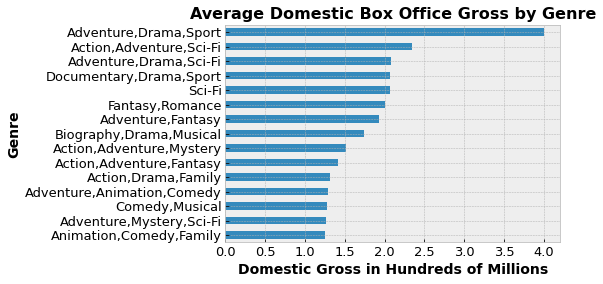

In [184]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Genres'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Average Domestic Box Office Gross by Genre', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in Hundreds of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold') 
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

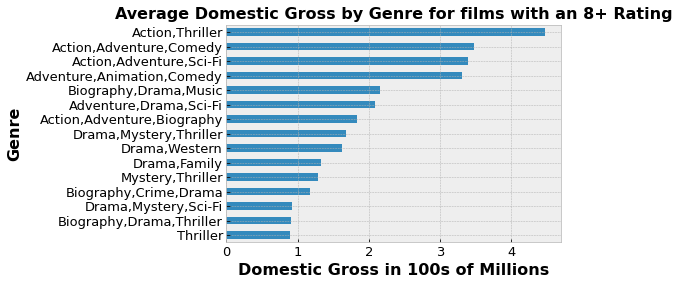

In [176]:
with plt.style.context('bmh'):
    (alljoined_8_or_better.groupby(['Genres'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Average Domestic Gross by Genre for films with an 8+ Rating', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of Millions', fontsize = 16, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 16, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)

#if you care about ratings, Action, Thriller, Adventure, Sci-Fi is the way to go 

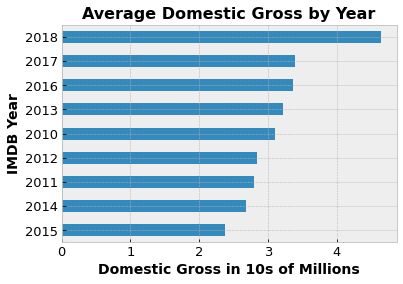

In [43]:
with plt.style.context('bmh'):
    (alljoined.groupby(['IMDB Year'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/10000000).plot(kind = 'barh')
    plt.title('Average Domestic Gross by Year', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 10s of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('IMDB Year', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
#why 2018 so high?  

I created a dataset from the master with data from only 2018, with the intention of exploring why it was the highest-grossing year. 

In [56]:
just2018 = alljoined[alljoined['IMDB Year'] == 2018]
just2018['Genres'].value_counts()

Drama                      23
Comedy,Drama,Romance        7
Comedy                      7
Action,Crime,Drama          6
Biography,Drama             6
                           ..
Comedy,Family,Fantasy       1
Adventure,Comedy,Sci-Fi     1
Comedy,Musical,Romance      1
Mystery,Thriller            1
Drama,Horror,Sci-Fi         1
Name: Genres, Length: 88, dtype: int64

The graph below shows that Action/Adventure/Sci-fi was the highest grossing genre in the highest grossing year, 2018. 

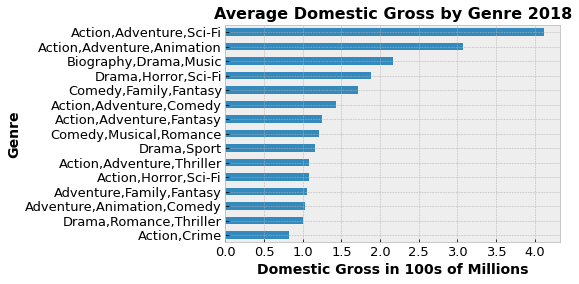

In [178]:
with plt.style.context('bmh'):
    (just2018.groupby(['Genres'])['Domestic Gross'].mean().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Average Domestic Gross by Genre 2018', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
#action/adventure/scifi


I was interested in exploring which genres had the most movies with a "high rating", meaning an 8 or better on IMDB. The bar graph below shows that Documentaries are the highest rated genre, with more than 2500 movies with a high rating. However, the graph "Sum Domestic Gross by Genre for films with an 8+ Rating on IMDB" lists "Documentary" toward the bottom of the list, with ~1.5 hundred million. This could be useful for gaining a reputation with independent documentarians. 

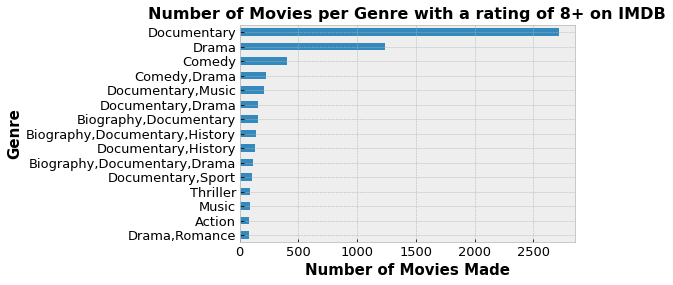

In [50]:
with plt.style.context("bmh"):
    imdb_8_or_better['Genres'].value_counts().head(15).plot(kind = 'barh')
    plt.title('Number of Movies per Genre with a rating of 8+ on IMDB', fontsize = 16, fontweight = 'bold')
    plt.xlabel('Number of Movies Made', fontsize = 15, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 15, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    plt.gca().invert_yaxis()

#if you're after ratings and don't necessarily care about popularity or gross income
#number of votes should be considered for a better idea 
#average number of votes per genres

Because of the strong positive correlation between Number of Votes and Domestic Box Office Gross, I decided to explore which genres garnered the most votes. 

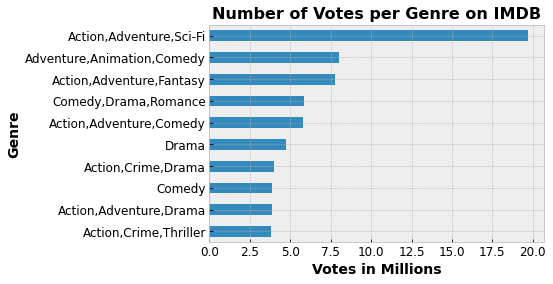

In [51]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Genres'])['Number of Votes'].sum().sort_values(ascending = False).head(10)/1000000).plot(kind = 'barh')
    plt.title('Number of Votes per Genre on IMDB', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Votes in Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Genre', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)


I was interested in which production studios had the highest Domestic Box Office revenue, and which of their movies did best. 

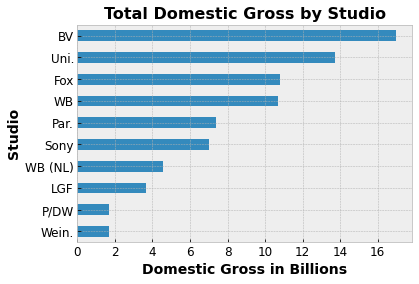

In [89]:
with plt.style.context('bmh'):
    (alljoined.groupby(['Studio'])['Domestic Gross'].sum().sort_values(ascending = False).head(10)/1000000000).plot(kind = 'barh')
    plt.title('Total Domestic Gross by Studio', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in Billions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Studio', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)

The top 3 studios that made the most money in the Domestic Box Office are BV, Universal, and Fox. I created 3 separate dataframes to analyze each studio individually. I discovered that there were some duplicate titles for films, which led to outliers on the graphs, so I dropped them.  

In [162]:
BVonly = alljoined[alljoined['Studio']== 'BV']
UNIonly = alljoined[alljoined['Studio']== 'Uni.']
FOXonly = alljoined[alljoined['Studio']== 'Fox']

In [163]:
UNIonly.dropna()
FOXonly.dropna()
BVonly.dropna()

,Title,Studio,Domestic Gross,Foreign Gross,BOM Year,tconst,Original Title,IMDB Year,Runtime (in minutes),Genres,Average Rating,Number of Votes
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218.0
5,Tangled,BV,200800000.0,391000000.0,2010,tt0398286,Tangled,2010,100.0,"Adventure,Animation,Comedy",7.8,366366.0
11,Prince of Persia: The Sands of Time,BV,90800000.0,245600000.0,2010,tt0473075,Prince of Persia: The Sands of Time,2010,116.0,"Action,Adventure,Fantasy",6.6,254975.0
31,The Sorcerer's Apprentice,BV,63200000.0,152100000.0,2010,tt0963966,The Sorcerer's Apprentice,2010,109.0,"Action,Adventure,Family",6.1,143862.0
68,The Last Song,BV,63000000.0,26100000.0,2010,tt1294226,The Last Song,2010,107.0,"Drama,Music,Romance",6.0,74914.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2753,Ralph Breaks the Internet,BV,201100000.0,328100000.0,2018,tt5848272,Ralph Breaks the Internet,2018,112.0,"Adventure,Animation,Comedy",7.1,85694.0
2757,Solo: A Star Wars Story,BV,213800000.0,179200000.0,2018,tt3778644,Solo: A Star Wars Story,2018,135.0,"Action,Adventure,Fantasy",7.0,226243.0
2763,Mary Poppins Returns,BV,172000000.0,177600000.0,2018,tt5028340,Mary Poppins Returns,2018,130.0,"Comedy,Family,Fantasy",6.9,52103.0
2774,The Nutcracker and the Four Realms,BV,54900000.0,119100000.0,2018,tt5523010,The Nutcracker and the Four Realms,2018,99.0,"Adventure,Family,Fantasy",5.5,18734.0


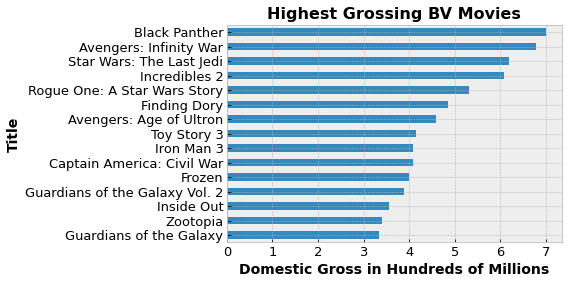

In [164]:
BVonly['Genres'].value_counts()
BVonly = BVonly.drop_duplicates(subset = 'Title')
        

with plt.style.context('bmh'):
    (BVonly.groupby(['Title'])['Domestic Gross'].sum().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Highest Grossing BV Movies', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in Hundreds of Millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    


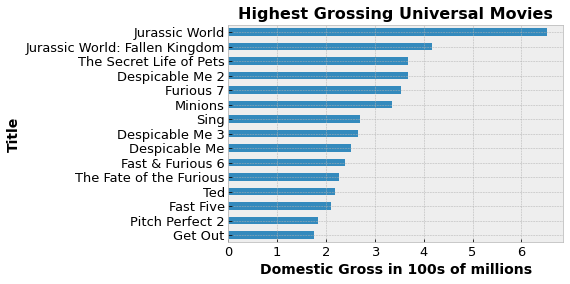

In [165]:
UNIonly = UNIonly.drop_duplicates(subset = 'Title')

with plt.style.context('bmh'):
    (UNIonly.groupby(['Title'])['Domestic Gross'].sum().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Highest Grossing Universal Movies', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)
    


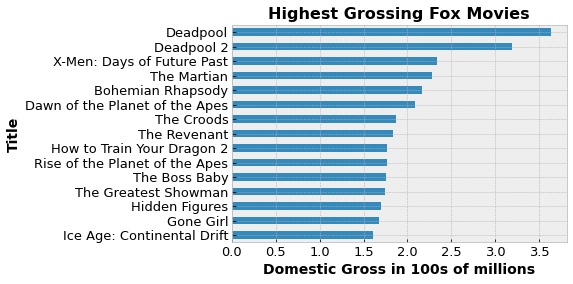

In [166]:
FOXonly = FOXonly.drop_duplicates(subset = 'Title')

with plt.style.context('bmh'):
    (FOXonly.groupby(['Title'])['Domestic Gross'].sum().sort_values(ascending = False).head(15)/100000000).plot(kind = 'barh')
    plt.title('Highest Grossing Fox Movies', fontsize = 16, fontweight = 'bold')
    plt.gca().invert_yaxis()
    plt.xlabel('Domestic Gross in 100s of millions', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Title', fontsize = 14, fontweight = 'bold')
    plt.xticks(fontsize = 13)
    plt.yticks(fontsize = 13)


# Results and Evaluation:

All data, unless specified, covers the time frame of 2010-2018

## Notable Correlations:

Domestic Gross & Foreign Gross have a strong positive correlation of .83. This indicates that films that do well in the Domestic Box Office will do well in the Foreign Box Office. 

Number of Votes & Domestic Gross have a moderate-strong positive correlation of .66. This means that more votes on IMDB tend to lead to a higher Domestic revenue. 

The correlation between Number of Votes & Foreign Gross is a little weaker, at .56, but still notable. 

Finally, Average Rating and Number of Votes has a mild positive correlation of .28, meaning that films with a higher rating can bring in more votes, or vice versa. 

-----------------------------------------------------------------

The first bar graph "Average Domestic Box Office Gross by Genre" represents the mean Domestic Gross of the highest-grossing genres. Adventure/Drama/Sport films blew the rest out of the water and made the most money at just about $400 million.

Because Average Rating has a positive relationship wtih Number of Votes, I wanted to determine how much  genres of the highest rated films 

The bar graph "Number of Movies per Genre with a rating of 8+ on IMDB" shows that Documentaries are the highest rated genre, with more than 2500 movies with a high rating. 

However, the graph "Sum Domestic Gross by Genre for films with an 8+ Rating on IMDB" lists "Documentary" toward the bottom of the list, with ~$1.5 hundred million. 

This could be useful for gaining a reputation with independent documentarians.

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***